# Form Recognition in Spark Ocr

End-to-end form recognition using PdfToForm.

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12/"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

import os
if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license

In [2]:
import pyspark
import sparkocr
import json
import os

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr.transformers import *
from sparkocr.utils import display_images
from sparkocr.enums import *

## Start spark session

In [3]:
from sparkocr import start
from pyspark import SparkConf

spark = start(jar_path = spark_ocr_jar_path)
spark

Spark version: 3.2.1
Spark NLP version: 4.1.0
Spark NLP for Healthcare version: 4.0.0
Spark OCR version: 4.2.0



## Load PDF, convert to image for rendering on notebook


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/FormRecognition/digital_forms/FDA-356h_func_R15_final_Sec_04-26-22_1.pdf
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


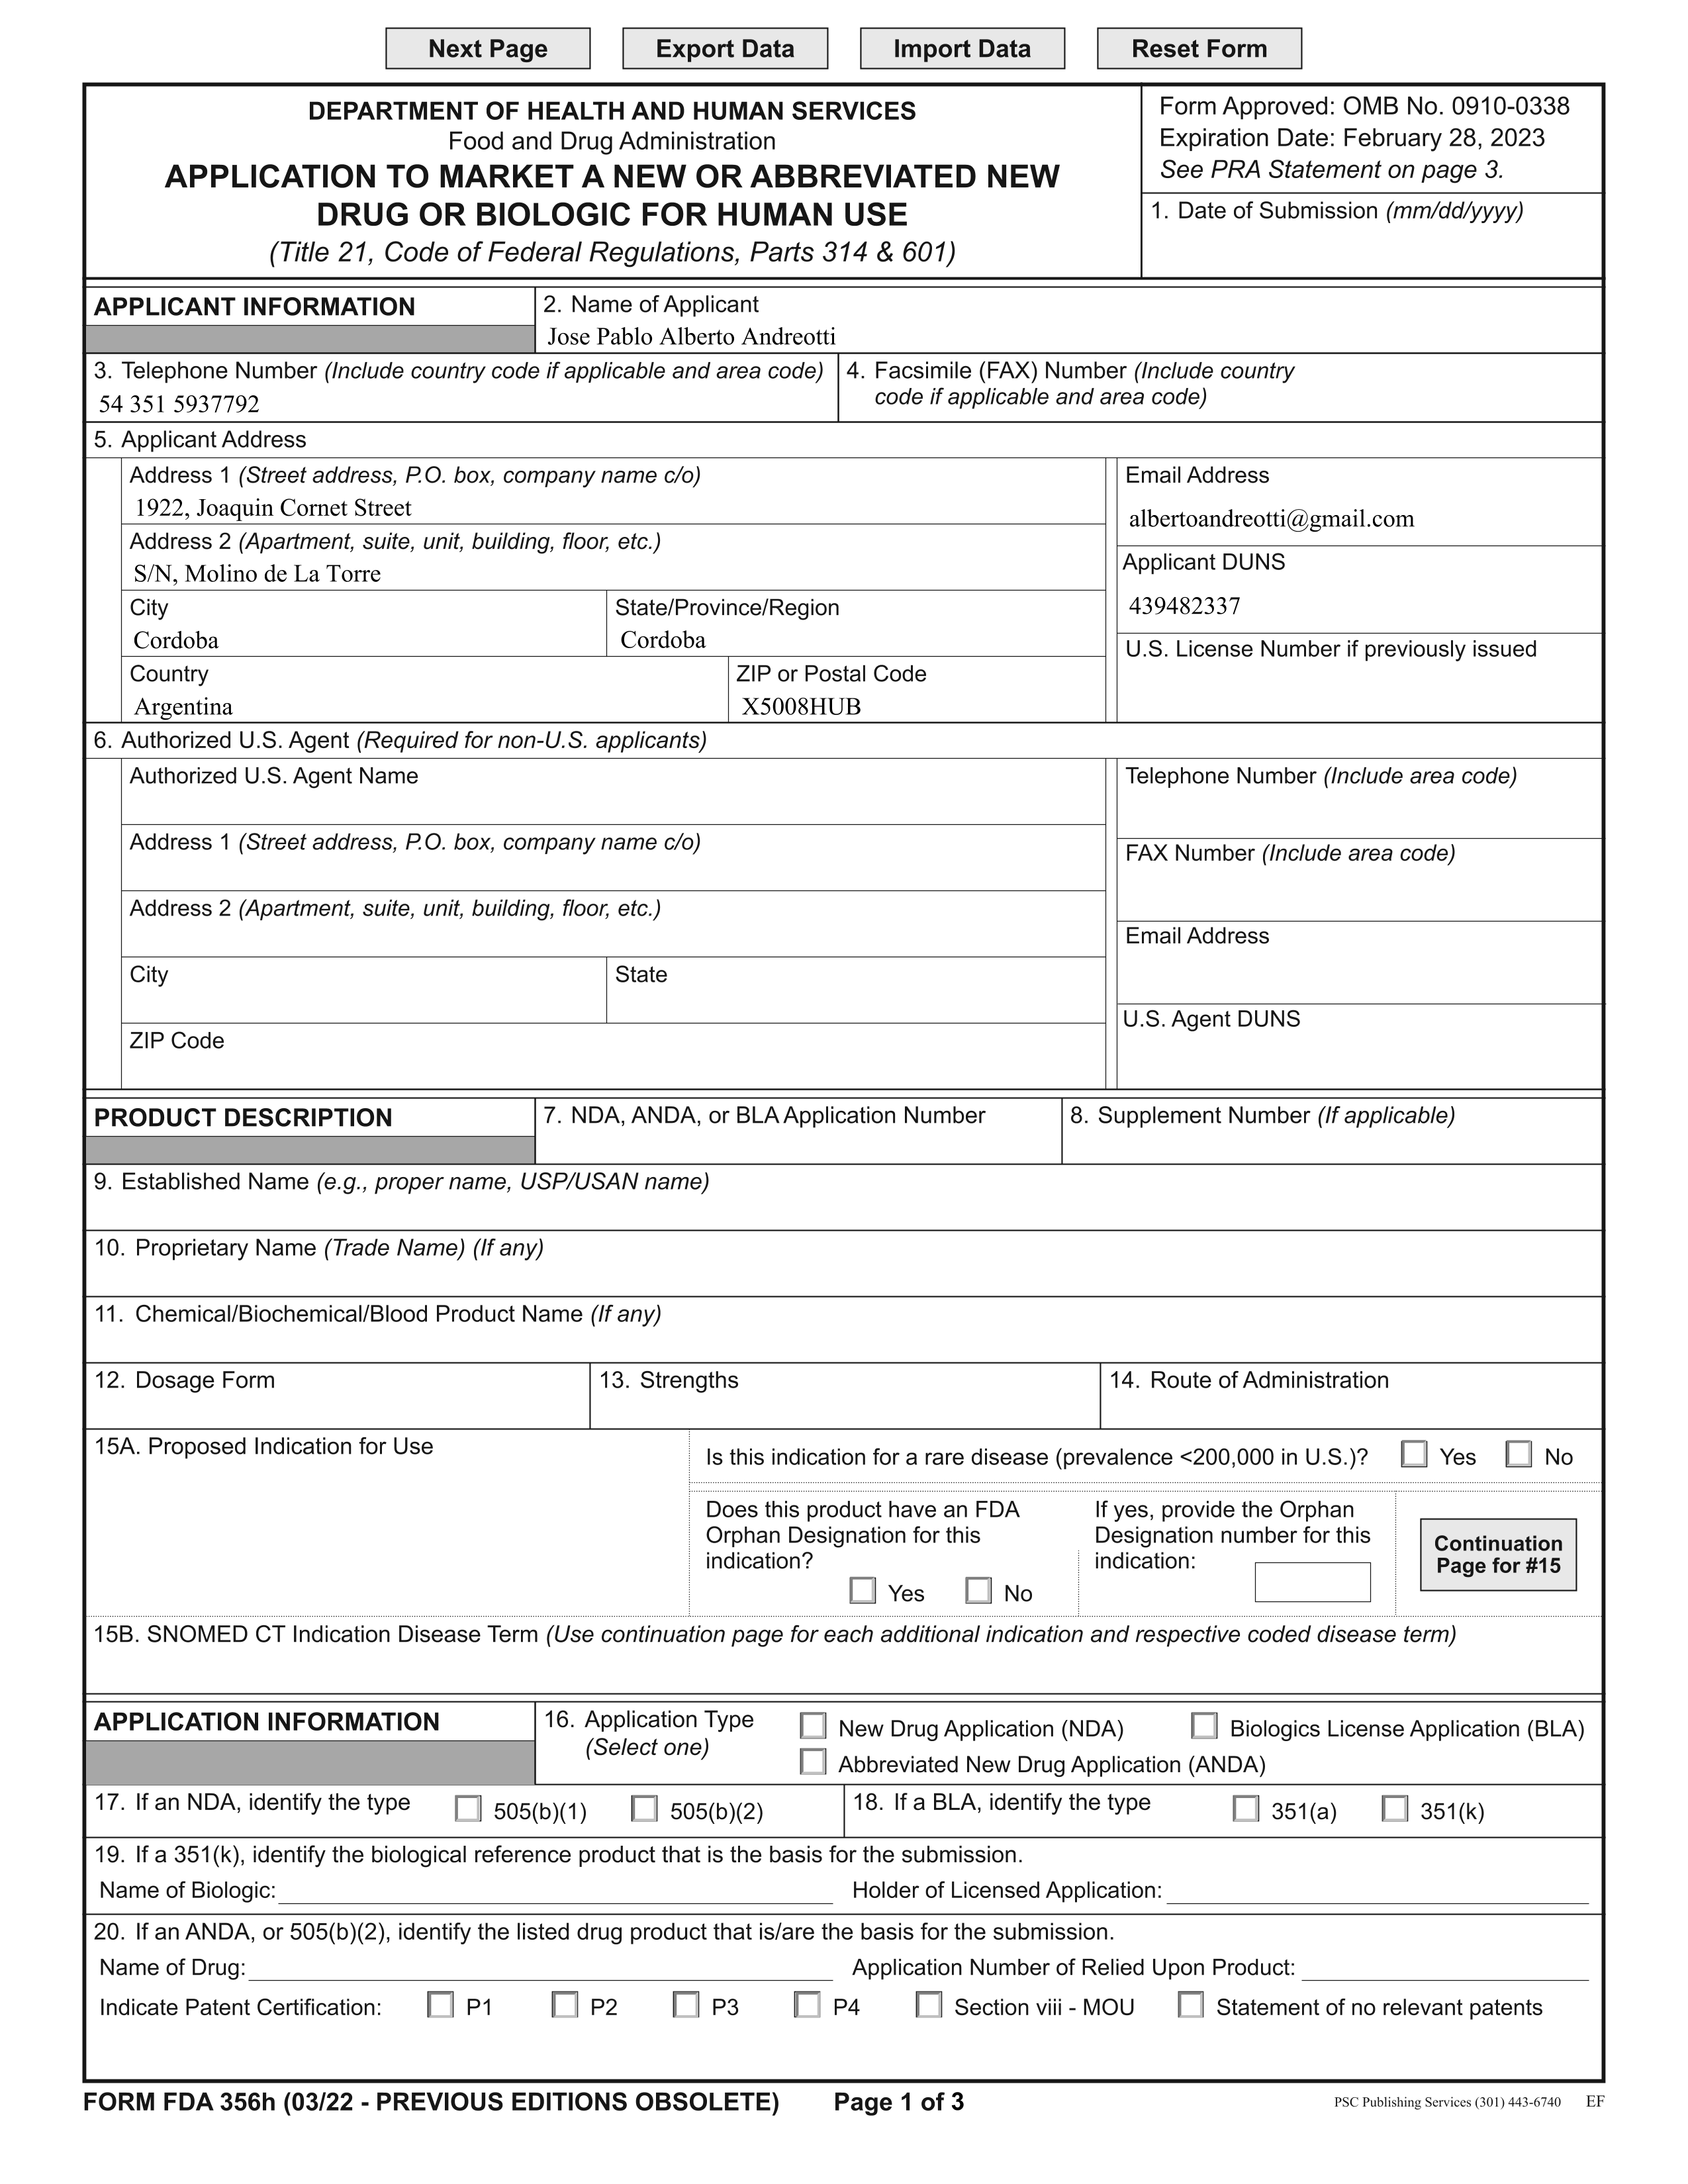


    Image #1:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/FormRecognition/digital_forms/FDA-356h_func_R15_final_Sec_04-26-22_1.pdf
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


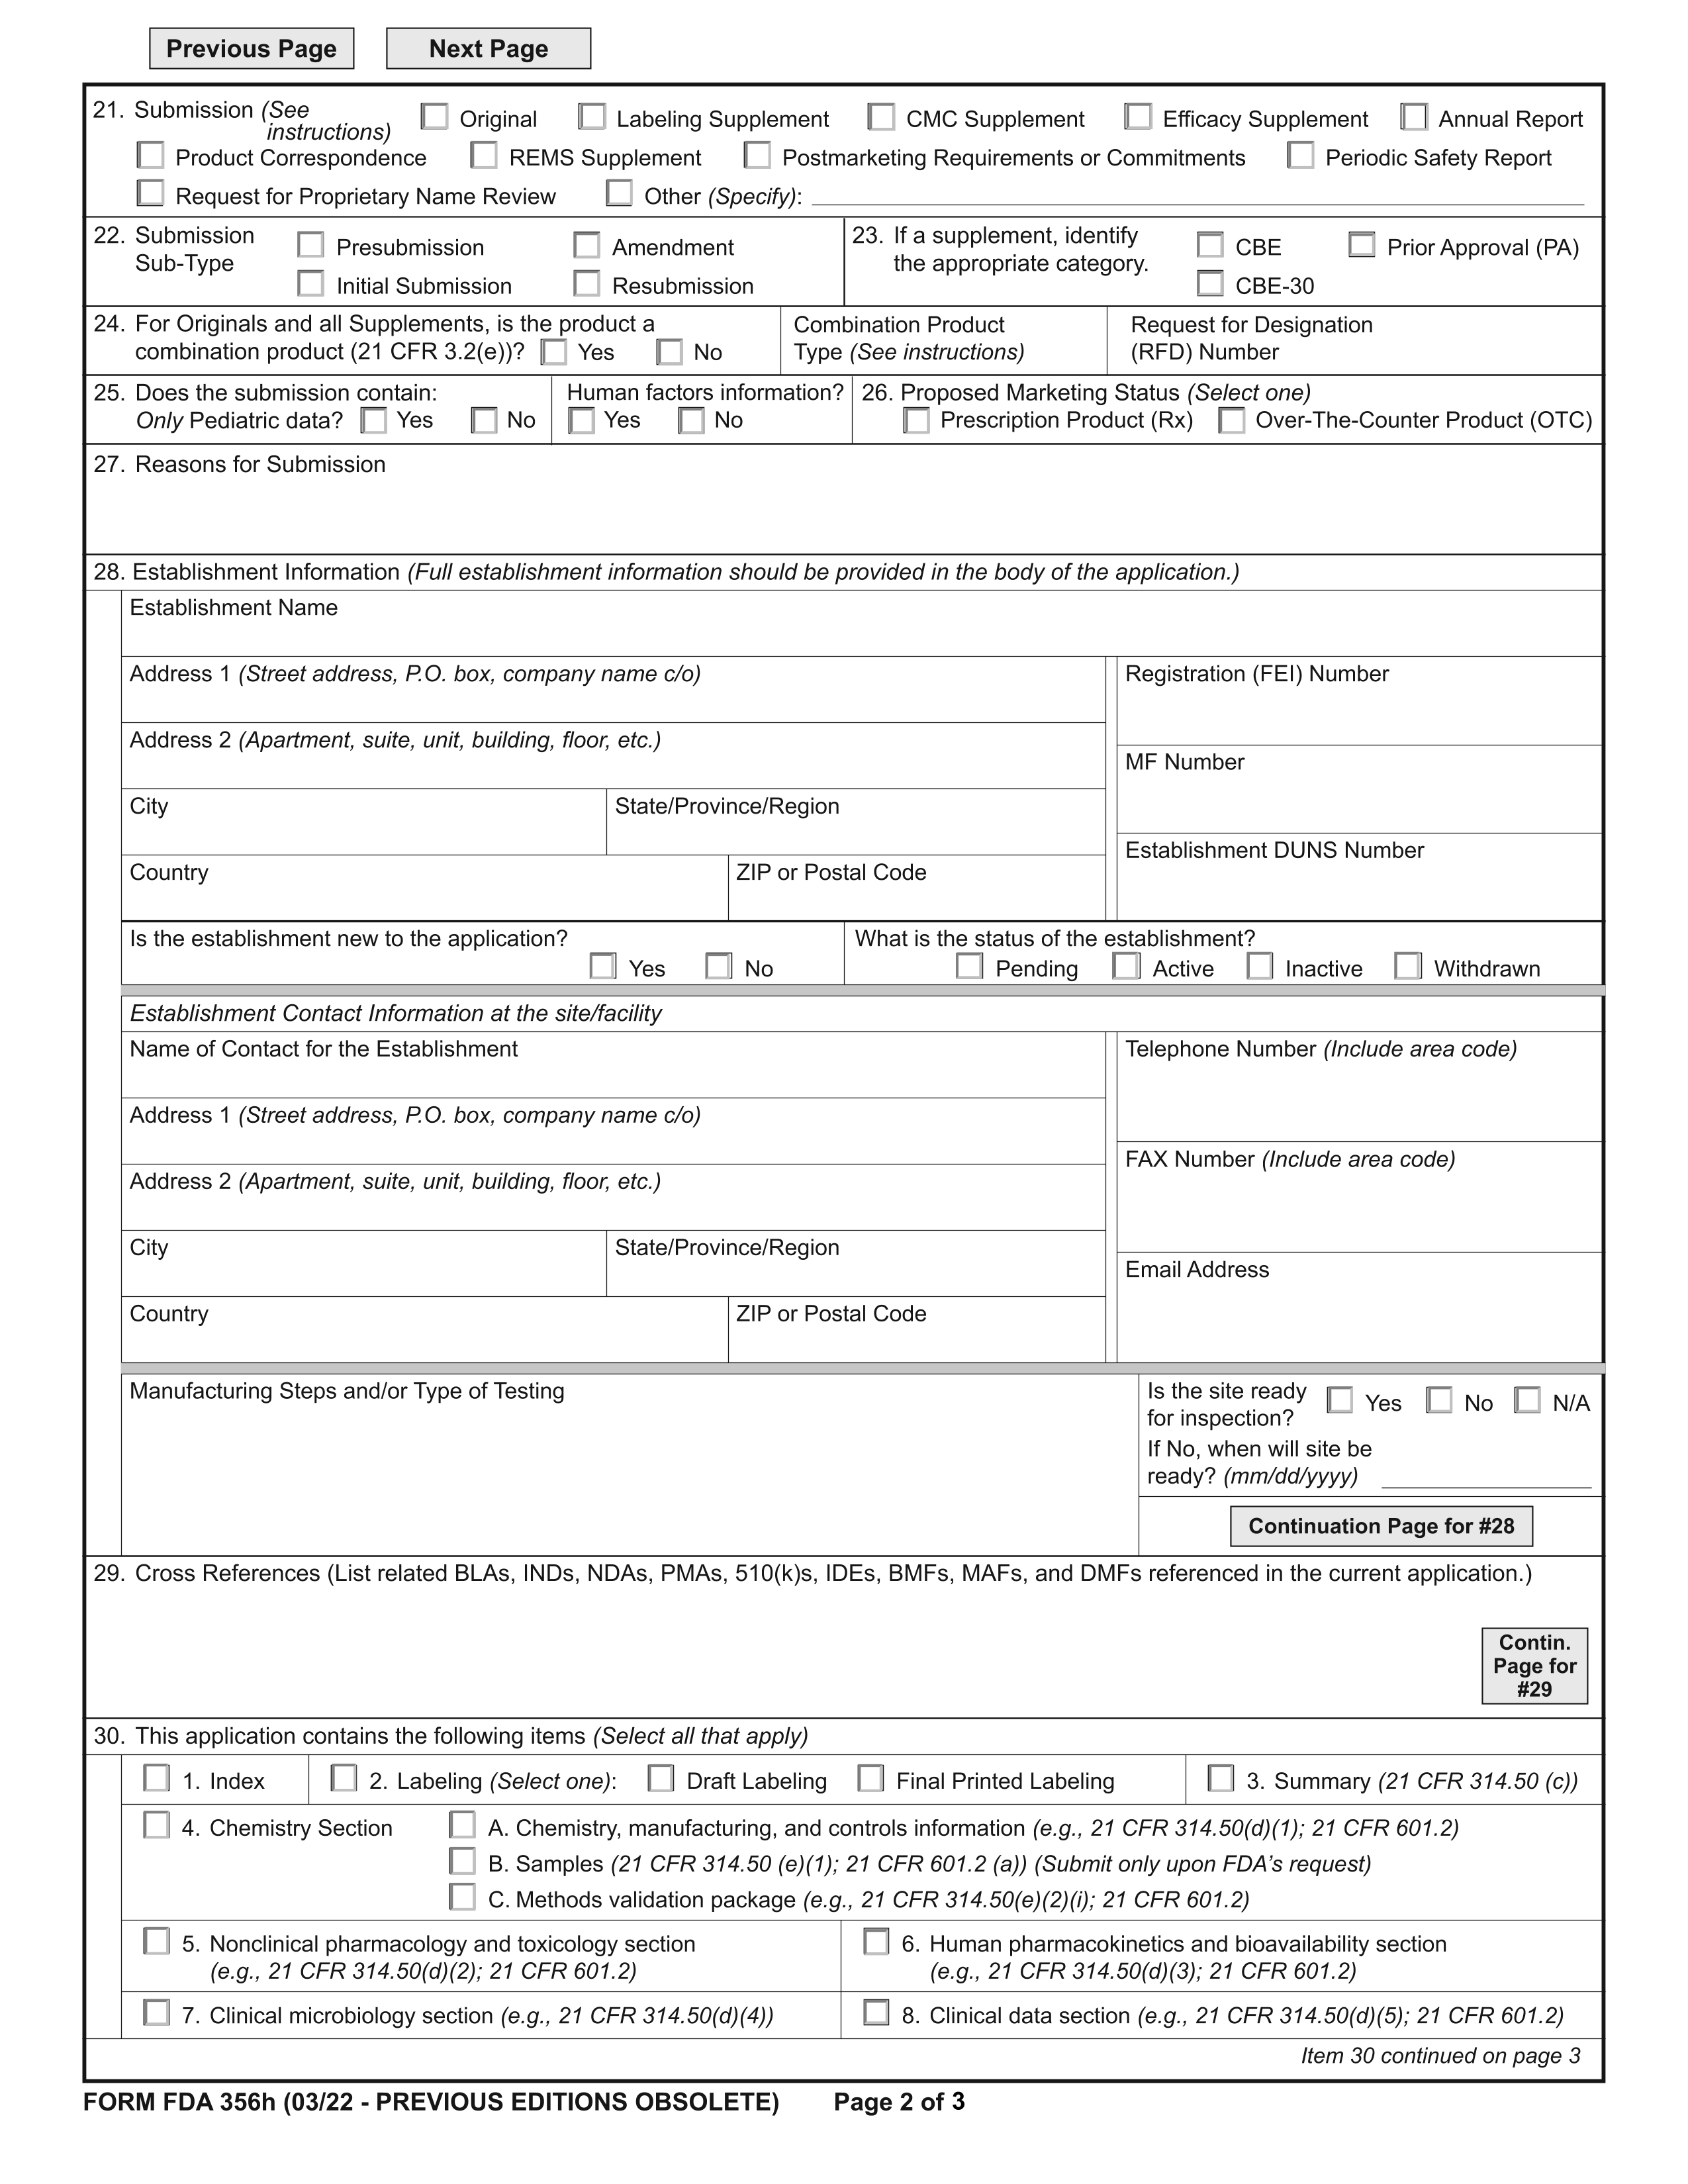


    Image #2:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/FormRecognition/digital_forms/FDA-356h_func_R15_final_Sec_04-26-22_1.pdf
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


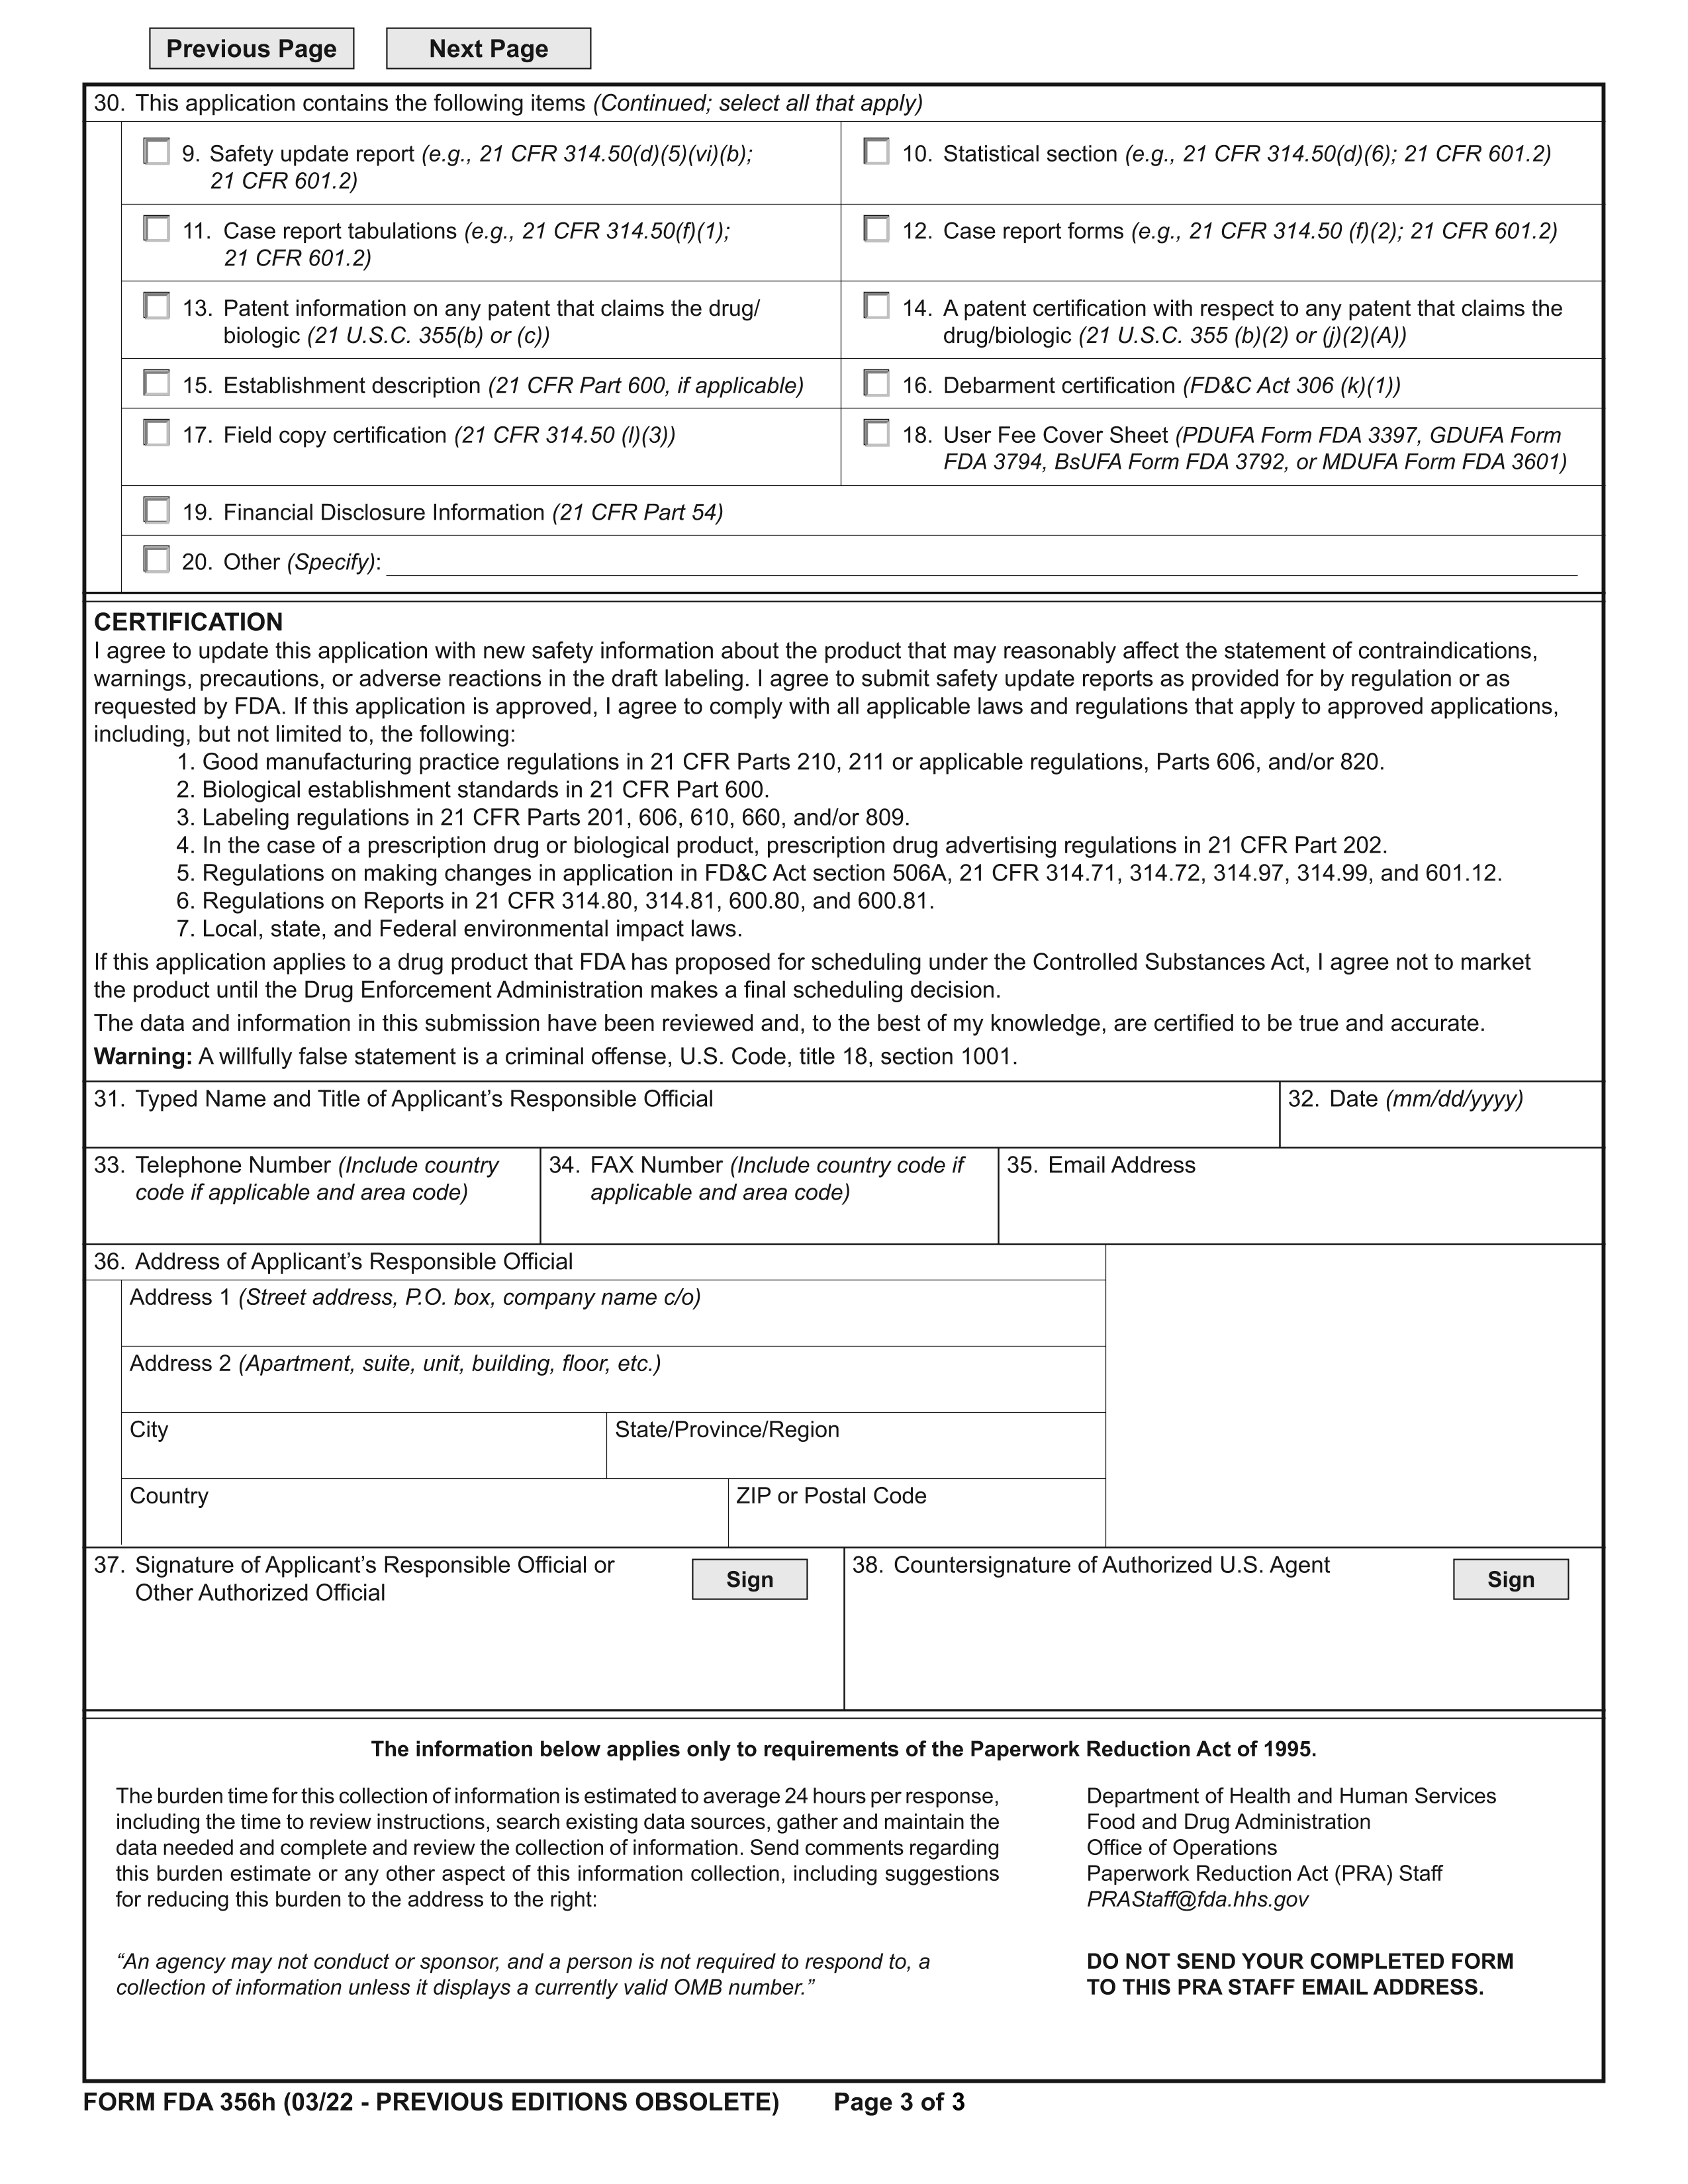

In [4]:
import pkg_resources
test_pdfs_path = './digital_forms/FDA-356h_func_R15_final_Sec_04-26-22_1.pdf'
bin_df = spark.read.format("binaryFile").load(test_pdfs_path)
display_images(PdfToImage().transform(bin_df))

## Define pipeline

In [5]:
from sparkocr.transformers import PdfToForm
pdf_to_form = PdfToForm()\
    .setOutputCol("form")


pipeline = PipelineModel(stages=[
    pdf_to_form
])

## Call pipeline

In [6]:
results = pipeline.transform(bin_df).cache()

In [7]:
results.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- form: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |    |    |-- fieldType: string (nullable = true)
 |    |    |-- coordinate: struct (nullable = true)
 |    |    |    |-- index: integer (nullable = false)
 |    |    |    |-- page: integer (nullable = false)
 |    |    |    |-- x: float (nullable = false)
 |    |    |    |-- y: float (nullable = false)
 |    |    |    |-- width: float (nullable = false)
 |    |    |    |-- height: float (nullable = false)
 |    |    |    |-- score: float (nullable = false)
 |    |    |    |-- label: string (nullable = true)
 |    |    |    |-- angle: float (nullable = false)



## Show results

In [8]:
results.select(f.explode("form").alias('kvs')).\
select(f.col("kvs.key"), f.col("kvs.value"), f.col("kvs.coordinate")).\
show(20, False)

+-------------------+----------------------------+--------------------------------------------------------+
|key                |value                       |coordinate                                              |
+-------------------+----------------------------+--------------------------------------------------------+
|Export Data        |                            |{0, 0, 225.11, 766.524, 300.904, 782.413, 0.0, 0, 0.0}  |
|Import Data        |                            |{1, 0, 311.248, 766.524, 386.825, 782.413, 0.0, 0, 0.0} |
|Reset Form         |                            |{2, 0, 397.189, 766.524, 472.766, 782.412, 0.0, 0, 0.0} |
|db_sbmsn_date      |                            |{3, 0, 416.684, 694.062, 578.38, 709.349, 0.0, 0, 0.0}  |
|db_aplcnt_name     |Jose Pablo Alberto Andreotti|{4, 0, 196.505, 664.433, 578.402, 677.102, 0.0, 0, 0.0} |
|db_aplcnt_phone    |54 351 5937792              |{5, 0, 33.7623, 639.443, 300.817, 653.002, 0.0, 0, 0.0} |
|db_aplcnt_fax      |       

# Use Fully Qualified Names instead
When forms are multi-level fully qualified names reflecting the entire path from the root of the form to an object can be obtained using the `setUseFullyQualifiedName` method.

In [9]:
pdf_to_form.setUseFullyQualifiedName(True)

test_pdfs_path = './digital_forms/f1120s.pdf'
bin_df = spark.read.format("binaryFile").load(test_pdfs_path)

results = pipeline.transform(bin_df).cache()

In [10]:
results.select(f.explode("form").alias('kvs')).\
select(f.col("kvs.key"), f.col("kvs.value"), f.col("kvs.coordinate")).\
show(20, False)

+-----------------------------------------------------------------------+-----------+----------------------------------------------------+
|key                                                                    |value      |coordinate                                          |
+-----------------------------------------------------------------------+-----------+----------------------------------------------------+
|topmostSubform[0].Page1[0].CalendarYear-TypePrint_ReadOrder[0].f1_01[0]|           |{0, 0, 219.0, 696.752, 345.6, 708.001, 0.0, 0, 0.0} |
|topmostSubform[0].Page1[0].CalendarYear-TypePrint_ReadOrder[0].f1_02[0]|           |{1, 0, 407.2, 696.752, 532.8, 708.001, 0.0, 0, 0.0} |
|topmostSubform[0].Page1[0].CalendarYear-TypePrint_ReadOrder[0].f1_03[0]|           |{2, 0, 552.8, 696.752, 576.0, 708.001, 0.0, 0, 0.0} |
|topmostSubform[0].Page1[0].CalendarYear-TypePrint_ReadOrder[0].f1_04[0]|Some  LLC  |{3, 0, 173.8, 671.998, 452.6, 685.999, 0.0, 0, 0.0} |
|topmostSubform[0].Page1[0]

## Without enabling useFullyQualifiedName option

In [11]:
pdf_to_form.setUseFullyQualifiedName(False)
results = pipeline.transform(bin_df).cache()

In [12]:
results.select(f.explode("form").alias('kvs')).\
select(f.col("kvs.key"), f.col("kvs.value"), f.col("kvs.coordinate")).\
show(20, False)

+--------+-----------+----------------------------------------------------+
|key     |value      |coordinate                                          |
+--------+-----------+----------------------------------------------------+
|f1_01[0]|           |{0, 0, 219.0, 696.752, 345.6, 708.001, 0.0, 0, 0.0} |
|f1_02[0]|           |{1, 0, 407.2, 696.752, 532.8, 708.001, 0.0, 0, 0.0} |
|f1_03[0]|           |{2, 0, 552.8, 696.752, 576.0, 708.001, 0.0, 0, 0.0} |
|f1_04[0]|Some  LLC  |{3, 0, 173.8, 671.998, 452.6, 685.999, 0.0, 0, 0.0} |
|f1_05[0]|32143      |{4, 0, 173.8, 648.0, 452.6, 662.001, 0.0, 0, 0.0}   |
|f1_06[0]|Fake Street|{5, 0, 173.8, 623.999, 452.6, 638.0, 0.0, 0, 0.0}   |
|f1_07[0]|12/31/2021 |{6, 0, 36.0, 671.998, 135.8, 685.999, 0.0, 0, 0.0}  |
|f1_08[0]|1243       |{7, 0, 36.0, 636.001, 135.8, 650.001, 0.0, 0, 0.0}  |
|c1_1[0] |Off        |{8, 0, 123.8, 626.002, 131.8, 634.002, 0.0, 0, 0.0} |
|f1_09[0]|431254     |{9, 0, 453.6, 671.998, 576.0, 685.999, 0.0, 0, 0.0} |
|f1_10[0]|  